# Introduction to text embeddings on S&P 500 news

objectives# 📌 Objectives

By the end of this notebook, students will be able to:

1. **Retrieve Financial News:**
   - Use the `yfinance` library to gather news headlines for all companies in the S&P 500 index.

2. **Clean and Structure Financial Text Data:**
   - Extract and organize relevant metadata (e.g., ticker, title, summary, publication date, URL) into a structured pandas DataFrame.

3. **Generate Text Embeddings:**
   - Apply a pre-trained sentence transformer model (`all-MiniLM-L6-v2`) to convert news headlines and summaries into numerical embeddings.

4. **Apply Clustering Techniques:**
   - Use K-Means clustering to identify groups of similar news articles based on semantic content.

5. **Determine Optimal Number of Clusters:**
   - Evaluate clustering quality using silhouette scores to find the best number of clusters.

6. **Visualize High-Dimensional Embeddings:**
   - Reduce the embedding space using PCA and visualize clusters in two dimensions.

7. **Interpret Cluster Themes:**
   - Analyze representative news


## Install and Import important librairies

In [1]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import yfinance as yf


## Get the list of stocks in the S&P 500 

In [2]:
# Read and print the stock tickers that make up S&P500
df_tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

display(df_tickers.head())

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [3]:
ticker_list = df_tickers['Symbol'].tolist()
len(ticker_list)

503

## Get the news of all 500 stocks in the S&P 500 Index
Use the yfinance library to retrieve the news of all 500 stocks in the index.
https://ranaroussi.github.io/yfinance/reference/yfinance.stock.html

### Get the news in a dictionary

In [4]:
# Create a dictionary where the keys are the symbols (tickers) of each 500 stocks 
# and the value is the output news from the yfinance library

# Dictionary to store news for each ticker
news_dict = {}

# Loop over all tickers in the S&P 500 list
for ticker in ticker_list:
    try:
        # Create a yfinance Ticker object
        stock = yf.Ticker(ticker)
        
        # Retrieve the news list for the stock
        news = stock.news
        
        # Store the news list in the dictionary under the ticker key
        news_dict[ticker] = news
        
        # Print how many news articles were retrieved for debugging
        print(f"News retrieved for {ticker}: {len(news)} articles")
        
    except Exception as e:
        # In case of error (e.g., network or ticker issues), print the error
        print(f"Error with {ticker}: {e}")
        
        # Store an empty list to keep dictionary keys consistent
        news_dict[ticker] = []


News retrieved for MMM: 10 articles
News retrieved for AOS: 10 articles
News retrieved for ABT: 10 articles
News retrieved for ABBV: 10 articles
News retrieved for ACN: 10 articles
News retrieved for ADBE: 10 articles
News retrieved for AMD: 10 articles
News retrieved for AES: 10 articles
News retrieved for AFL: 10 articles
News retrieved for A: 10 articles
News retrieved for APD: 10 articles
News retrieved for ABNB: 10 articles
News retrieved for AKAM: 10 articles
News retrieved for ALB: 10 articles
News retrieved for ARE: 10 articles
News retrieved for ALGN: 10 articles
News retrieved for ALLE: 10 articles
News retrieved for LNT: 10 articles
News retrieved for ALL: 10 articles
News retrieved for GOOGL: 10 articles
News retrieved for GOOG: 10 articles
News retrieved for MO: 10 articles
News retrieved for AMZN: 10 articles
News retrieved for AMCR: 10 articles
News retrieved for AEE: 10 articles
News retrieved for AEP: 10 articles
News retrieved for AXP: 10 articles
News retrieved for A

### Structure the news into a pandas dataframe 

Your final dataframe should have the following columns: 
- TICKER
- TITLE (of the news)
- SUMMARY (of the news)
- PUBLICATION_DATE (of the news)
- URL (of the news)

Note: all of those fields are provided in the yfinance news component. Refer to the library documentation.

In [5]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS
# Create an empty list to hold each news article as a dictionary (row)
rows = []

# Loop over each ticker and its list of news articles in the news dictionary
for ticker, news_list in news_dict.items():
    # Loop over each news item for the current ticker
    for news_item in news_list:
        # Extract the 'content' dictionary from the news item; default to empty dict if missing
        content = news_item.get('content', {})

        # Extract the title of the news article; empty string if not found
        title = content.get('title', '')
        
        # Extract the summary of the news article; empty string if not found
        summary = content.get('summary', '')
        
        # Extract the publication date; empty string if not found
        pub_date = content.get('pubDate', '')

        # Safely extract the URL to the full news article:
        # First get the 'clickThroughUrl' dictionary, if it exists and is a dict,
        # then get the 'url' key inside it. Otherwise, set URL to empty string.
        click_url = content.get('clickThroughUrl')
        if isinstance(click_url, dict):
            url = click_url.get('url', '')
        else:
            url = ''

        # Append the extracted info as a dictionary (row) to the rows list
        rows.append({
            'TICKER': ticker,
            'TITLE': title,
            'SUMMARY': summary,
            'PUBLICATION_DATE': pub_date,
            'URL': url
        })

# Convert the list of dictionaries into a pandas DataFrame with proper columns
df_news = pd.DataFrame(rows)
df_news

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL
0,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","HON, MMM, CSL, and FSS are well-positioned to ...",2025-07-21T09:45:00Z,https://finance.yahoo.com/news/zacks-industry-...
1,MMM,"Stock Market News for Jul 21, 2025",U.S. stock markets closed mostly lower n Frida...,2025-07-21T08:22:00Z,https://finance.yahoo.com/news/stock-market-ne...
2,MMM,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,3M Co (MMM) reports a 12% increase in adjusted...,2025-07-19T07:05:47Z,https://finance.yahoo.com/news/3m-co-mmm-q2-20...
3,MMM,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,Industrial conglomerate 3M (NYSE:MMM) reported...,2025-07-19T05:30:58Z,https://finance.yahoo.com/news/mmm-q1-deep-div...
4,MMM,Dow Falls as Trump Reportedly Seeks Higher EU ...,The Dow Jones Industrial Average fell Friday f...,2025-07-18T21:11:10Z,https://finance.yahoo.com/news/dow-falls-trump...
...,...,...,...,...,...
5011,ZTS,Looking for Stocks with Positive Earnings Mome...,The Zacks Earnings ESP is a great way to find ...,2025-07-18T13:00:03Z,https://finance.yahoo.com/news/looking-stocks-...
5012,ZTS,"Starbucks downgraded, Oracle initiated: Wall S...","Starbucks downgraded, Oracle initiated: Wall S...",2025-07-17T13:46:52Z,https://finance.yahoo.com/news/starbucks-downg...
5013,ZTS,Here's Why Zoetis (ZTS) is a Strong Growth Stock,"Wondering how to pick strong, market-beating s...",2025-07-17T13:45:03Z,https://finance.yahoo.com/news/heres-why-zoeti...
5014,ZTS,Here's What to Expect From Zoetis’ Next Earnin...,Zoetis is scheduled to report its second-quart...,2025-07-17T11:33:47Z,https://finance.yahoo.com/news/heres-expect-zo...


## Exploring text embeddings

- Use the open-source model: 'sentence-transformers/all-MiniLM-L6-v2' to create embeddings on the news title and summary
- Add a column to your news dataframe called EMBEDDED_TEXT using ONLY the TITLE of the news
- Add a column to your news dataframe called EMBEDDINGS, which contains the embedding of EMBEDDED_TEXT


In [6]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS
from sentence_transformers import SentenceTransformer

# Load the pre-trained embedding model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Create a new column 'EMBEDDED_TEXT' in the DataFrame using only the TITLE
df_news['EMBEDDED_TEXT'] = df_news['TITLE'].fillna('')  # Replace NaN titles with empty string

# Generate embeddings for all the texts in 'EMBEDDED_TEXT'
# This will create a list of vectors (one per news title)
embeddings = model.encode(df_news['EMBEDDED_TEXT'].tolist(), show_progress_bar=True)

# Add the embeddings as a new column 'EMBEDDINGS' in the DataFrame
df_news['EMBEDDINGS'] = embeddings.tolist()  # Convert numpy arrays to lists for DataFrame compatibility

# Display the updated DataFrame
df_news.head()


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,EMBEDDED_TEXT,EMBEDDINGS
0,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","HON, MMM, CSL, and FSS are well-positioned to ...",2025-07-21T09:45:00Z,https://finance.yahoo.com/news/zacks-industry-...,"Zacks Industry Outlook Highlights Honeywell, 3...","[-0.021629245951771736, -0.07978328317403793, ..."
1,MMM,"Stock Market News for Jul 21, 2025",U.S. stock markets closed mostly lower n Frida...,2025-07-21T08:22:00Z,https://finance.yahoo.com/news/stock-market-ne...,"Stock Market News for Jul 21, 2025","[-0.03746962547302246, -0.04381367936730385, 0..."
2,MMM,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,3M Co (MMM) reports a 12% increase in adjusted...,2025-07-19T07:05:47Z,https://finance.yahoo.com/news/3m-co-mmm-q2-20...,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,"[-0.08080153167247772, -0.0298007782548666, -0..."
3,MMM,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,Industrial conglomerate 3M (NYSE:MMM) reported...,2025-07-19T05:30:58Z,https://finance.yahoo.com/news/mmm-q1-deep-div...,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,"[-0.01950260065495968, -0.07280391454696655, 0..."
4,MMM,Dow Falls as Trump Reportedly Seeks Higher EU ...,The Dow Jones Industrial Average fell Friday f...,2025-07-18T21:11:10Z,https://finance.yahoo.com/news/dow-falls-trump...,Dow Falls as Trump Reportedly Seeks Higher EU ...,"[0.01862621307373047, -0.03162863478064537, 0...."


## Using K-means clustering on news embeddings
to simplify, keep only one news for each company (ticker), you should have 500 rows in your news dataframe

In [14]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS
# Keep only 1 news per ticker (first occurrence)
news_unique_df = df_news.drop_duplicates(subset='TICKER', keep='first').reset_index(drop=True)

# Check resulting shape
print(f"Shape after filtering: {news_unique_df.shape}")

# Extract embeddings as a plain Python list of lists
embedding_list = news_unique_df['EMBEDDINGS'].tolist()

# Run KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(embedding_list)

# Add clusters to the dataframe
news_unique_df['CLUSTER'] = clusters

#  Preview result
print(news_unique_df[['TICKER', 'CLUSTER']].head())

Shape after filtering: (502, 7)
  TICKER  CLUSTER
0    MMM        2
1    AOS        3
2    ABT        0
3   ABBV        8
4    ACN        0


### Identify the number of clusters using the silhouette score

- Using a for loop, do the clustering with different k values (number of clusters), test 1 to 6 clusters
- Compute the silhouette score for every k value
- Plot the silhouette score for different k values

#### Try different values of k and compute silhouette scores

In [8]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS
# List to store silhouette scores for each k
silhouette_scores = []

# Range of k values to test (from 2 to 6)
k_values = range(2, 7)

# Loop over k values
for k in k_values:
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    
    # Fit KMeans on the embeddings
    kmeans.fit(embedding_list)
    
    # Get the cluster labels for each data point
    cluster_labels = kmeans.labels_
    
    # Compute the silhouette score for the current k
    score = silhouette_score(embedding_list, cluster_labels)
    
    # Append the score to the list
    silhouette_scores.append(score)
    
    # Print the score for tracking
    print(f"k={k}, Silhouette Score={score:.4f}")

k=2, Silhouette Score=0.0383
k=3, Silhouette Score=0.0444
k=4, Silhouette Score=0.0244
k=5, Silhouette Score=0.0281
k=6, Silhouette Score=0.0287


#### Plot silhouette scores

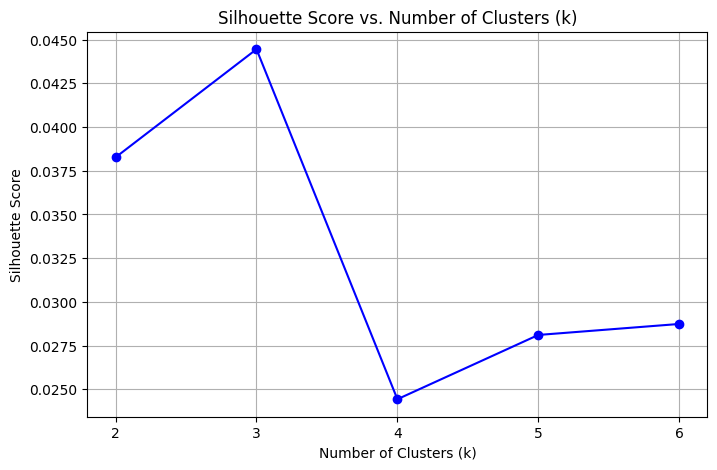

In [9]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title("Silhouette Score vs. Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(k_values)  # Ensure x-axis ticks match k values
plt.grid(True)
plt.show()

#### Identify the Best k

In [10]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS
# Find the k with the highest silhouette score
best_k = k_values[silhouette_scores.index(max(silhouette_scores))]

print(f"The optimal number of clusters (k) is: {best_k}")

The optimal number of clusters (k) is: 3


#### Cluster the embeddings using 3 clusters (k=3)

In [11]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS
# Convert the embeddings column to a list of lists (plain Python lists)
embeddings = list(news_unique_df['EMBEDDINGS'].values)

# Create and fit the KMeans model with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
news_unique_df['CLUSTER'] = kmeans.fit_predict(embeddings)

# Show the resulting clusters
news_unique_df[['TICKER', 'CLUSTER']].head()

,TICKER,CLUSTER
0,MMM,2
1,AOS,0
2,ABT,0
3,ABBV,2
4,ACN,0


### Visualize the 2 first PCA Components of your embeddings

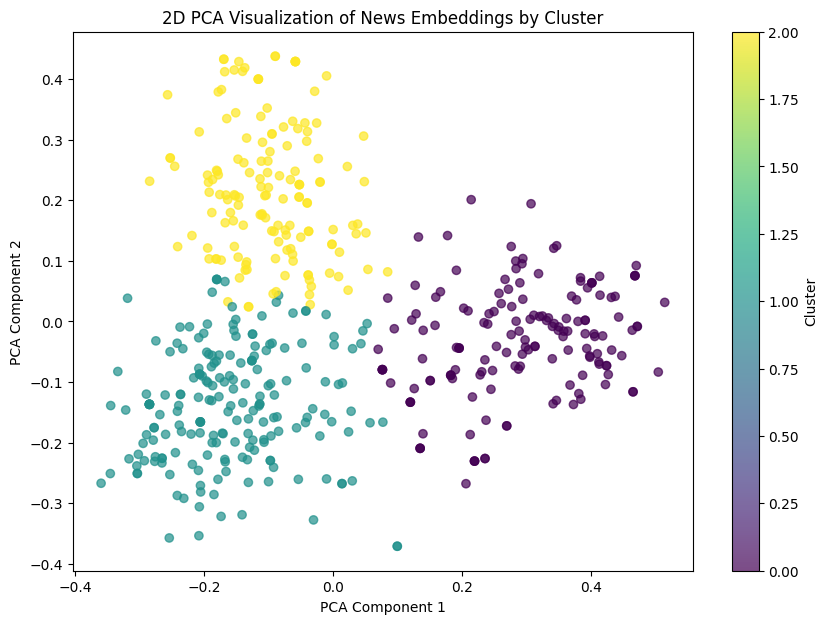

In [12]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS
# Extract embeddings from your dataframe as a list of lists
embeddings = list(news_unique_df['EMBEDDINGS'].values)

# Apply PCA to reduce embeddings to 2 dimensions
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)

# Add the 2D PCA components to the dataframe
news_unique_df['PCA1'] = embeddings_2d[:, 0]
news_unique_df['PCA2'] = embeddings_2d[:, 1]

# Plot the PCA components, coloring by cluster
plt.figure(figsize=(10, 7))
scatter = plt.scatter(news_unique_df['PCA1'], news_unique_df['PCA2'], 
                      c=news_unique_df['CLUSTER'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA Visualization of News Embeddings by Cluster')
plt.show()

#### Analyze the content of each cluster
- Add the kmeans cluster label to your news dataframe
- Print the content of each cluster and analyze it

In [13]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS
# Group by cluster and print some representative news titles and summaries
for cluster_num in sorted(news_unique_df['CLUSTER'].unique()):
    print(f"\n--- Cluster {cluster_num} ---")
    cluster_data = news_unique_df[news_unique_df['CLUSTER'] == cluster_num]
    
    # Show a sample of news titles and summaries for this cluster
    for idx, row in cluster_data[['TITLE', 'SUMMARY']].head(5).iterrows():
        print(f"Title: {row['TITLE']}")
        print(f"Summary: {row['SUMMARY']}\n")
    
    print(f"Total news in cluster {cluster_num}: {len(cluster_data)}")


--- Cluster 0 ---
Title: A. O. Smith (AOS) Reports Earnings Tomorrow: What To Expect
Summary: Water heating and treatment solutions company A.O. Smith (NYSE:AOS) will be announcing earnings results this Thursday before market open. Here’s what to look for.

Title: Tenet Beats Q2 Earnings on Strong Patient Volumes, Hikes '25 EPS View
Summary: THC's Q2 earnings benefit on the back of strong volumes, facility buyouts, higher acuity and favorable payer mix. It currently expects 2025 adjusted EPS within $15.55-$16.21, up from the earlier view of $11.99-$13.12.

Title: Interpublic Group Earnings Beat Estimates in Q2, Revenues Slide Y/Y
Summary: IPG posts 23% y/y EPS growth in second-quarter 2025. Yet, revenues slip 6.7% and margins face sharp y/y declines.

Title: General Motors and Coca-Cola earnings reveal an important reminder: Opening Bid top takeaways
Summary: It's time for earnings to take the lead story slot for investors.

Title: AES Corporation’s Q2 2025 Earnings: What to Expect
Su



## Question Section

Take time to reflect on what you've implemented and observed. Answer the following questions in a separate markdown cell or notebook file:

---

### Technical Understanding

#### 1️⃣ How might the choice of embedding model (e.g., MiniLM vs. a larger transformer) affect your clustering results and interpretation?

MiniLM is a strong choice for clustering tasks due to its efficiency on standard laptop hardware and its ability to generate high-quality semantic embeddings. These embeddings capture sufficient contextual information to form meaningful clusters, allowing for faster processing, fewer memory issues, and quicker experimentation.

In contrast, larger transformer models like MPNet or BERT-large produce more detailed and nuanced embeddings. These can enhance cluster separation and yield richer semantic interpretations, which is particularly valuable when working with complex or subtle textual content. However, these models come with significant computational costs, often requiring longer runtimes, GPUs, or cloud-based resources.

Overall, MiniLM offers a practical balance between embedding quality and resource usage. While it may not capture semantic subtleties as effectively as larger models, it is well-suited for exploratory analysis on constrained hardware, as demonstrated in this case.


---

#### 2️⃣ What would be the differences in embeddings if you used only the TITLE, only the SUMMARY, or the combination of both? How could you empirically test this?

Using only the TITLE captures the main headline, which is usually concise and designed to grab attention. While titles provide the core topic, they can sometimes be ambiguous or sensationalized, leading to embeddings that may not fully reflect the article’s content.

Using only the SUMMARY offers more detailed context and deeper semantic information about the article. However, summaries can include additional background or less relevant details, which might introduce noise into the embeddings.

Combining both TITLE and SUMMARY generally produces richer embeddings that blend the succinctness of the title with the contextual depth of the summary. This can lead to improved clustering by better capturing the overall meaning and nuances of each news article.

---

#### 3️⃣ In what situations would using a different dimensionality reduction method (e.g., t-SNE, UMAP) be preferable over PCA for visualization of embeddings?

PCA is a linear dimensionality reduction method that identifies the directions of maximum variance in the data. It is effective when the relationships in the dataset are primarily linear and when the goal is to understand the global variance structure. PCA is computationally efficient and serves well as a first step in reducing dimensionality while retaining as much overall information as possible.

In contrast, embeddings—particularly those derived from text or other complex data—often exhibit nonlinear patterns where local relationships between points carry more meaningful information. In such cases, nonlinear methods like t-SNE and UMAP are more suitable. These techniques are designed to preserve local neighborhood structures, resulting in visualizations where clusters and subtle groupings are more clearly defined.

t-SNE is particularly good at highlighting local structures and revealing clusters, though it may be computationally demanding and less effective at preserving global patterns. UMAP tends to be faster, handles larger datasets more efficiently, and balances the preservation of both local and global structures, making it a versatile choice for many embedding visualization tasks.

Overall, PCA is well-suited for capturing global trends and reducing dimensions efficiently. However, for detailed exploration of cluster relationships and nonlinear structures in high-dimensional embeddings, t-SNE or UMAP generally offer more insightful visualizations. The choice between the two often depends on dataset size and the desired balance between computational speed and structure preservation.

---

### Data Analysis and Interpretation

#### 4️⃣ Based on your cluster analysis, identify at least two potential challenges you faced in interpreting the clusters and propose strategies to address them.

Challenges in interpreting the clusters are:

**1. Overlapping Topics Across Clusters**  
Many articles cover similar subjects such as earnings, management changes, or industry trends, which often appear in different clusters. This overlap makes it challenging to assign clear and distinct meanings to each cluster.

**2. Limited Semantic Context from Title-Only Embeddings**  
Using only the news title for embeddings provides limited information since titles are short and often designed to attract attention. This can result in clusters that group articles based on superficial similarities instead of deeper semantic connections.

**How to Improve it**  
One way to address these issues is to combine the title and summary before generating embeddings. This approach enriches the input text, allowing the model to capture both the concise intent of the title and the detailed context of the summary. It can improve the quality of the embeddings, leading to more coherent and semantically meaningful clusters. Additionally, testing with larger transformer models or domain-specific fine-tuning can further enhance cluster separation. Post-clustering techniques like topic modeling or manual review may also help clarify and refine interpretations.

---

#### 5️⃣ Did you observe any outliers in your 2D visualization? How would you identify and handle these outliers in a production pipeline?


In the visualization, there are points that appear scattered far from the dense cluster formations. These isolated points may represent potential outliers in the embedding space. Outliers can result from unusual language structures, extremely short or long texts, or even errors in the original news data. 

##### Identifying Outliers in a Production Pipeline

1. **Distance-Based Detection**  
   Calculate the distance of each embedding from its assigned cluster centroid using metrics such as Euclidean or cosine distance. Points that exceed a defined threshold, such as the 95th percentile of intra-cluster distances, can be flagged as outliers.

2. **Density-Based Methods**  
   Use algorithms like DBSCAN or Local Outlier Factor (LOF) that detect samples lying in low-density regions compared to surrounding data.

3. **Reconstruction Error in Autoencoders**  
   Train an autoencoder on the embeddings. Points with high reconstruction error indicate embeddings that deviate significantly from the learned manifold.

4. **Statistical Thresholding**  
   For each PCA component or embedding dimension, compute Z-scores or apply interquartile range filtering to detect extreme values.

##### Handling Outliers

- Exclude confirmed noise from clustering and further analysis to avoid distorting cluster shapes.

- Assign borderline cases to the nearest cluster based on similarity measures to retain as much data as possible.

- Create a dedicated "outlier" cluster to monitor these items separately and evaluate whether they represent rare but meaningful patterns.

- Manually review outliers since they may reveal unique or significant news articles, such as breaking news or unexpected events.


---

#### 6️⃣ If you could assign a 'label' or 'theme' to each cluster you obtained, what would they be? How confident are you in these assignments, and what could you do to validate them systematically?

##### What ‘label’ or ‘theme’ would you assign to each cluster?

These keywords provide a general context about the new to support a classification
- **Cluster 0: Industrial and Corporate News**  
  Includes articles about manufacturing, infrastructure, and organizational changes (e.g., Honeywell, Figma, 3M).  

- **Cluster 1: Financial Results and Earnings Reports**  
  Contains news on quarterly earnings, analyst forecasts, and company financial performance (e.g., Alphabet, Verizon, Intel).  

- **Cluster 2: Market Trends and Investment Strategies**  
  Focuses on dividend portfolios, stock market movements, and actions by major investors (e.g., S&P 500, dividend strategies).  



##### How confident are you in these assignments?

The confidence level is **moderate**:  
- Clear patterns support these labels.  
- However, there is some overlap between clusters, especially between corporate news and financial reports.  



##### What could you do to validate them systematically?

1. **Keyword Analysis**  
   Extract representative terms from each cluster using TF-IDF or embeddings to confirm thematic consistency.  

2. **Topic Modeling**  
   Apply LDA or BERTopic to check if the dominant topics align with the proposed labels.  

3. **Random Manual Review**  
   Analyze random samples of articles from each cluster to assess thematic consistency.  

4. **Mapping to External Taxonomies**  
   Compare clusters with recognized taxonomies (such as GICS sectors) to ensure alignment with external categories.  

5. **Inter-Annotator Agreement**  
   Involve multiple independent reviewers to assign labels and measure agreement (e.g., using Cohen’s Kappa).  


---

### Critical Thinking

#### 7️⃣ If news sentiment was incorporated into the analysis, how might this influence the clustering structure and interpretation of the clusters in a financial analysis context?

If we added sentiment to the analysis, it could change how the clusters form and what they mean. Right now, we’re grouping articles based on what they talk about (semantics), but adding sentiment would let us also consider how they talk about it—positive, negative, or neutral.

For example:

- A cluster might group positive news like strong earnings or partnerships.

- Another might collect negative events like layoffs or lawsuits.

This makes the clusters easier to interpret from a market reaction perspective. Investors don’t just react to topics—they react to tone.

We could use models like VADER or FinBERT to score sentiment and either:

- Add it as a feature in the embedding,

- Or use it to label/color the clusters.

---

#### 8️⃣ Discuss the limitations of using k-means clustering for news embeddings. What alternative clustering methods could address these limitations, and under what conditions would you prefer them?


##### Limitations of K-Means Clustering

1. K-Means assumes clusters are roughly spherical and of similar size. This is often not the case with high-dimensional text embeddings, where the structure can be more complex and non-linear.

2. Specify `k` in advance is needed, but it’s not always clear how many clusters exist in natural language data. Choosing the wrong `k` can lead to misleading results.

3. K-Means uses mean values for centroids, so outliers can pull clusters in unintended directions and distort the results.

4. It relies purely on distance, without considering how densely points are grouped or connected. This can lead to splitting dense areas or merging sparse ones incorrectly.

---

##### Alternative Clustering Methods

1. **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**
   Groups data based on density rather than distance. It automatically identifies the number of clusters and handles noise (outliers) well.

   * Use it when you expect **arbitrary-shaped clusters** or **want to detect outliers**.
   * Works best when clusters have varying shapes and densities.

2. **Hierarchical Clustering**
   Builds a tree of clusters based on distances between points. You can cut the tree at different levels to form more or fewer clusters.

   * Useful when you want a **multi-level view** of the data or don't want to fix `k` from the start.
   * It can be computationally expensive for large datasets.

3. **HDBSCAN (Hierarchical DBSCAN)**
   A combination of DBSCAN and hierarchical clustering. It improves performance on variable density clusters and gives more robust results than DBSCAN.

   * Preferred for **text embeddings** where cluster shapes and densities vary.
   * It can also return "noise" points that don’t belong to any cluster.

---

##### Alternatives

* Use **DBSCAN or HDBSCAN** when the number of clusters is unknown and you expect irregular shapes or noise.
* Use **hierarchical clustering** when you want to explore the structure of the data at multiple levels.
* Stick with **K-Means** when the data is large, roughly balanced, and clusters are expected to be spherical and separable.


---

#### 9️⃣ How could the approach in this notebook be extended to analyze the potential impact of news clusters on stock price movements over time? Sketch a high-level pipeline you would implement to test this.



##### Pipeline to Analyze Impact of News Clusters on Stock Prices

1. **Collect Historical Stock Price Data**
   Download daily stock prices (open, close, volume) for all tickers related to your news articles.

2. **Align News Articles with Stock Prices**
   Match each news article’s ticker and publication date with the corresponding stock price data.

3. **Calculate Price Movements**
   Compute stock returns (e.g., daily or over several days) following each news article.

4. **Label Price Movements**
   Categorize returns into labels such as positive, negative, or neutral based on thresholds.

5. **Aggregate Price Movements by News Cluster**
   Group articles by their cluster and summarize average returns and movement distributions per cluster.

6. **Perform Statistical Analysis or Modeling**
   Evaluate whether different news clusters have different effects on stock price movements using tests or predictive models.

---

#### 10️⃣ Imagine your clustering shows clear groups of news, but your downstream task (e.g., prediction of stock movement) does not improve. What might explain this disconnect between clear clusters and predictive utility?

Sometimes, even if the clusters of news look very clear and meaningful, they don’t improve how well we can predict stock price changes. Here are some reasons why:

1. **Clusters show topics, not what actually moves prices**
   The groups might just separate news by theme (like earnings or management), but these themes don’t always cause big price changes.

2. **Timing issues**
   The stock market might react before or after the news, or the effect might happen slowly. So the cluster label might not match the price change right away.

3. **Important info is missing**
   Clustering looks at text similarity but ignores things like how positive or negative the news is, or other market factors that influence prices.

4. **Clusters are noisy or too general**
   Sometimes clusters mix different types of news or have irrelevant info, making it hard to use them for prediction.

5. **Simple prediction models**
   If the model trying to predict price moves is too basic, it might not learn to use the cluster info well.

